In [1]:
'''
initialize the world coordinates for a set of known points
- a point above the center of the arena
- center of each feeder
'''
import os 
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage import measure

import sys
sys.path.append("../utils/")
from load_matlab_data import loadmat_sbx
from scipy.io import savemat

In [2]:
# set the file paths
arena_folder = 'Z:/Isabel/arena/v0/arena_model/'
image_file = 'arena_model-01.png'
# save_dir = "Z:/Isabel/presentations/230913_lab_meeting/"

In [3]:
# load the arena model image
img = mpimg.imread(arena_folder + image_file)
img = img[:, :, 0]

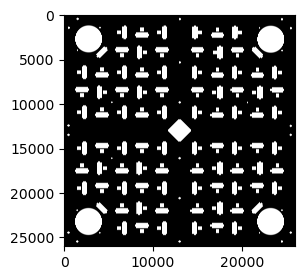

In [4]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(img, cmap='gray')
plt.show()

In [5]:
# get all the arena objects and their stats
blobs = img > 0.5
labels, num_blobs = measure.label(blobs, background=0, return_num=True)
props = measure.regionprops(labels)

In [6]:
''' Find the feeder centers '''
# feeders are the largest items
areas = np.asarray([])
for p in props:
    areas = np.append(areas, p.area)
feeder_bool = areas > 7e6
feeder_idx = np.arange(num_blobs)[feeder_bool]
n_feeders = np.sum(feeder_bool)
assert n_feeders == 4

In [7]:
# get the centroid for each feeder
for i in feeder_idx:
    if i == feeder_idx[0]:
        feeder_centers = props[i].centroid
    else:
        feeder_centers = np.row_stack([feeder_centers, props[i].centroid])

# format as x, y
feeder_centers = np.flip(feeder_centers, axis=1)

# order red, yellow, green, blue
feeder_centers_reorder = np.zeros_like(feeder_centers)
feeder_centers_reorder[0] = feeder_centers[3]
feeder_centers_reorder[1] = feeder_centers[2]
feeder_centers_reorder[2] = feeder_centers[0]
feeder_centers_reorder[3] = feeder_centers[1]

In [8]:
feeder_centers = feeder_centers_reorder
print('raw feeder centers:')
print(feeder_centers)

raw feeder centers:
[[23256.43959118 23256.44441123]
 [ 2756.44032697 23256.44414984]
 [ 2774.53050375  2705.50276399]
 [23274.49985317  2741.6160212 ]]


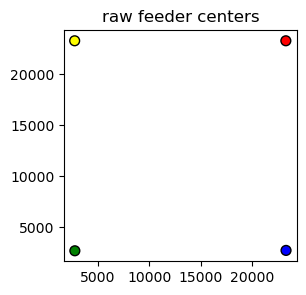

In [9]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
colors = ['red', 'yellow', 'green', 'blue']
ax.scatter(feeder_centers[:, 0], feeder_centers[:, 1], 
           facecolors=colors, edgecolors='k',
           alpha=1, lw=1, s=50)
lims = ax.get_ylim()
ax.set_title('raw feeder centers')
plt.show()

In [10]:
''' Find the water dish corners '''
water_idx = np.arange(num_blobs)[(areas > 3e6) & (areas < 7e6)][0]
water_bbox = props[water_idx].bbox
water_center = img.shape[0] / 2

# corners of the water dish, counter-clockwise from the top
water_corners = np.asarray([
    [water_center, water_bbox[2]],
    [water_bbox[1], water_center],
    [water_center, water_bbox[0]],
    [water_bbox[-1], water_center]
])

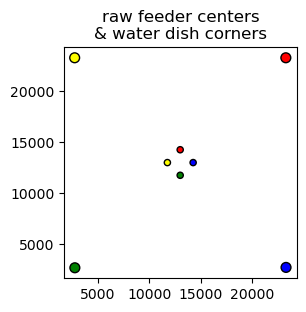

In [11]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(feeder_centers[:, 0], feeder_centers[:, 1], 
           facecolors=colors, edgecolors='k',
           alpha=1, lw=1, s=50)
ax.scatter(water_corners[:, 0], water_corners[:, 1], 
           facecolors=colors, edgecolors='k',
           alpha=1, lw=1, s=20)
lims = ax.get_ylim()
ax.set_title('raw feeder centers\n& water dish corners')
plt.show()

In [12]:
# concatenate and normalize s.t. the arena is 2x2, centered at 0
raw_pts = np.row_stack([feeder_centers, water_corners])
half_len = img.shape[0] / 2
norm_pts = (raw_pts / half_len) - 1

# convert to 3D
pts_3d = np.column_stack((norm_pts, np.zeros(n_feeders + 4)))

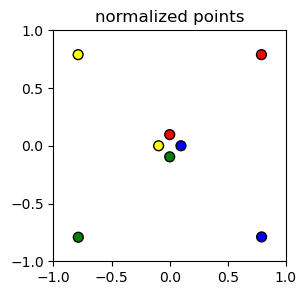

In [13]:
colors = ['red', 'yellow', 'green', 'blue', 
          'red', 'yellow', 'green', 'blue']

f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(norm_pts[:, 0], norm_pts[:, 1], 
           facecolors=colors, edgecolors='k',
           alpha=1, lw=1, s=50)
ax.set_xticks(np.arange(-1, 1.2, 0.5))
ax.set_yticks(np.arange(-1, 1.2, 0.5))
ax.set_title('normalized points')

plt.show()
# f.savefig(f'{save_dir}known_world_pts_2d.png', dpi=600, bbox_inches='tight')

In [14]:
print(norm_pts)

[[ 0.78895689  0.78895726]
 [-0.78796613  0.78895724]
 [-0.78657458 -0.7918844 ]
 [ 0.79034614 -0.78910646]
 [ 0.          0.09669231]
 [-0.09561538  0.        ]
 [ 0.         -0.09561538]
 [ 0.09669231  0.        ]]


In [15]:
# add the center point
center_pt = np.asarray([0, 0, 1/10])

In [16]:
# world point coords
world_coords_simple = np.row_stack((center_pt, pts_3d))

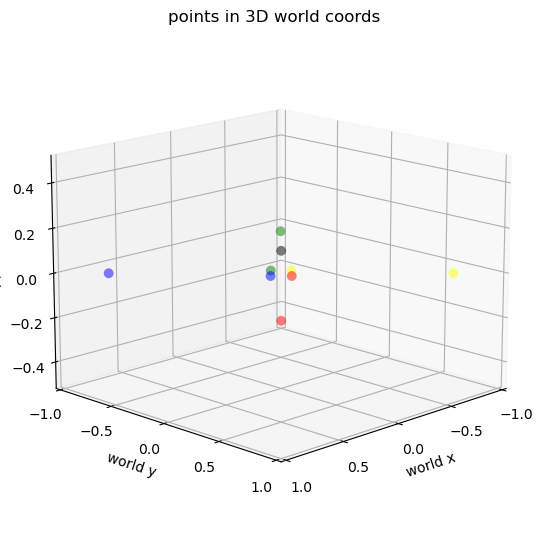

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = plt.axes([0, 0, 1, 1], projection='3d')

x_pts = world_coords_simple[:, 0].copy()
y_pts = world_coords_simple[:, 1].copy()
z_pts = world_coords_simple[:, 2].copy()
colors = ['black', 'red', 'yellow', 'green', 'blue', 
          'red', 'yellow', 'green', 'blue']

ax.scatter(
        x_pts, y_pts, z_pts,
        c=colors,
        alpha=0.5, lw=0, s=50)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-0.5, 0.5)

ax.set_xticks(np.arange(-1, 1.2, 0.5))
ax.set_yticks(np.arange(-1, 1.2, 0.5))

ax.set_xlabel('world x')
ax.set_ylabel('world y')
ax.set_zlabel('world z')

ax.view_init(azim=45, elev=15)
ax.set_title('points in 3D world coords')

plt.show()
# fig.savefig(f'{save_dir}known_world_pts_3d.png', dpi=600, bbox_inches='tight')

In [18]:
file_path = 'C:/Users/ilow1/Documents/code/bird_pose_tracking/calibration_files/'
folder = 'known_points/'
np.save(f'{file_path}{folder}points_3d_simple.npy', world_coords_simple)

In [ ]:
# save for matlab
pts_dict = {"points_3d_target":pts_3d_known}
savemat(f"{file_path}{folder}pts_3d_known.mat", pts_dict)